## Identification of sustainability-focused campaigns on the kickstarter crowdfunding platform using NLP and ML boosted with swarm intelligence
--- ------------------
<div>
Data Analysis: part 2
<br>
Submitted by: Jossin Antony<br>
Affiliation: THU Ulm<br>
Date: 11.06.2024
</div>

## Overview
- [Introduction](#A.-Introduction)
- [Extraction of key words](#B.-Extraction-of-key-words)
- [Attention!](#C.-Attention!)
- [Categorize the datafrae](#D.-Categorize-the-dataframe)
- [To Dos](#E.-To-Dos)

### A. Introduction
--- -------------------

We continue our analysis with the filtered dataset from part 1. The data set consists of features 'is_environmental' and 'is_social' which are thought to be very essential in the upcoming analyses. However, only 1% of these columns hold values. 
In this script, we try to populate the rest of the columns with values using NLP analyses.

In [10]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

import numpy as np
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
import re
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

from pprint import PrettyPrinter
pp= PrettyPrinter()

In [11]:
#load the dataset
df= pd.read_csv('./data/dataframe_stripped_features.csv', low_memory=False)

In [12]:
print('We print 2 random rows of the dataset for preliminary impressions.')
pd.set_option('display.max_colwidth', 50)
df.sample(2)


We print 2 random rows of the dataset for preliminary impressions.


,campaign_name,blurb,main_category,sub_category,is_environmental,is_social,country_code,duration_in_months,goal_usd_category,is_success
13344,GIGABUSTER - Blazing action platformer (Demo A...,Action platformer inspired by Mega Man Zero an...,Games,Video Games,NaN,NaN,US,1,1k-10k,goal_achieved
25900,Club Saje,I will be opening a teen club. This club will ...,Dance,Performances,NaN,NaN,US,2,50k_plus,fail


### B. Extraction of key words
--- -------------------

We try to extract the main keywords which will help to classify the blurbs- description of the project-  as environmentally or socially relevant.

Some of the data are manually curated and classified as socially or environmentally relevant. We start with the analysis of this data in the hopes that it might reveal some clues to understand how the data was actually classified, beyond the human notions of what is socially or environmentally relevant.

First we replace all the NaN values with the term 'unspecified'. Next we check how many samples were manually curated.

In [13]:
# fill the fields with NaN as 'unspecified'
df = df.fillna('unspecified')
nrows= len(df[(df['is_environmental']!='unspecified') | (df['is_social']!='unspecified')])
print(f'Observation: The Dataset has {nrows} rows with an "Yes" or "No" value in "is_environment" and "is_social" columns.\n\
Note: Due to manual curation all the selected samples have values in both "is_environmental" and "is_social" columns.\n')

Observation: The Dataset has 1642 rows with an "Yes" or "No" value in "is_environment" and "is_social" columns.
Note: Due to manual curation all the selected samples have values in both "is_environmental" and "is_social" columns.



Next we check the proportion of 'yes' and 'No' values.



In [14]:
#Check if the classes are balanced
print(df['is_environmental'].value_counts())
print(df['is_social'].value_counts())

is_environmental
unspecified    137972
No               1606
Yes                36
Name: count, dtype: int64
is_social
unspecified    137972
No               1621
Yes                21
Name: count, dtype: int64


**Observation:** The classes are not well balanced. We see that an overwhelming number of samples are classified 'NO' for social or environmental relevance. Classical classification machine learnings cannot be applied here, because the 'null accuracy' (prediction 'No') is well over 90%.

As an alternate (and easy) approach, we try to find the most important words that appear in the 'blurb' classified as socially/environmentally relevant. 

We start with the ['tf-idf'](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) algorithm. The aim is to calculate the mean tf-idf scores of the words that appear in the corpus marked as socially or environmentlly relevant and later attempt to use the appearance of these words to classify uncategorized extracts.

Note:
- We use [stemming](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) to find the 'root' form of the words that appear in the corpus. We start the analysis with [snowball stemming](https://www.ibm.com/topics/stemming#Types+of+stemming+algorithms).
- The [stopwords in english](https://gist.github.com/sebleier/554280) (e.g. 'and', 'these') are omitted from the analysis. Similarly, all numbers, symbols etc. are also ignored (e.g: 'covid-19' -> 'covid').
- To increase the amount of training data, the 'campaign_name' is also considered along with 'blurb'.

In [15]:
#Easy test: tf-idf
# tf-idf 
#STOP_WORDS='english', exclude also numbers
STOP_WORDS = list(text.ENGLISH_STOP_WORDS.union([str(i) for i in range(10)]))
MIN_DOCS= .05
TOKEN_PATTERN= '(?u)\\b[a-zA-Z]{2,}\\b'

def stem(extracts_list):
    stemmer = SnowballStemmer("english")
    return [' '.join([stemmer.stem(word.lower()) for word in word_tokenize(extract)]) for extract in extracts_list]

def extract_to_stemmed_list(extract):
    extract= re.sub(r'[\W,]+', ' ', extract).replace('-', ' ').lower().split()
    return stem(extract)

def get_keywords_count(df, ranked_words, count_column, column_ranked_words='ranked_words', threshold=0.05):
    #Returns the detected keywords and its count in a text corpus. The keywords are words from ranked_words list above a certain defined threshold
    df[count_column] = 0
    df['combined_description']=''
    
    df.loc[:,'combined_description'] = df.loc[:,'campaign_name'] + ' ' + df.loc[:,'blurb']

    #Get list of words appearing in the ranked_words and greater than the defined threshold
    df.loc[:,column_ranked_words] = df.loc[:,'combined_description'].apply(
        lambda text_description: [word if word in ranked_words.index and ranked_words.loc[word] > threshold else '' 
                        for word in extract_to_stemmed_list(text_description)]
                        ).apply(lambda word: list(filter(None, word)))
    
    #Get count of ranked words for each row
    df.loc[:,count_column]= df.loc[:,column_ranked_words].apply(len)
    #Drop the combined description
    df.drop(columns=['combined_description'], axis=1,inplace=True)
    return df

def get_word_count_in_classified_blurbs(df, count_column):
    #Find the prescence of keywords in rows with already manually classified descriptions
    return df[count_column].apply(lambda x: 'No keyword' if x == 0 else 'at least one keyword').value_counts()

#Function to get a list of top ranked words in a literature corpus using tf-idf algorithm
def get_ranked_words(vocabulary:list,text_extracts:list, stop_words=STOP_WORDS, min_df= MIN_DOCS, token_pattern=TOKEN_PATTERN, *args, **kwargs):
    #tf_idf_model
    tf_idf_model = TfidfVectorizer(stop_words=stop_words, min_df= min_df, token_pattern=token_pattern)
    #stem extracts list
    vocabulary = stem([text for text in vocabulary])
    #Vectorization of corpus
    tf_idf_vector = tf_idf_model.fit(vocabulary)
    tf_idf_vector = tf_idf_model.transform(text_extracts)
    # #Get original terms in the corpus
    words_set = tf_idf_model.get_feature_names_out()
    # #Data frame to show the TF-IDF scores of each document
    df_tf_idf = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector, columns=words_set)
    # Calculate the sum of TF-IDF scores for each word
    word_importance = df_tf_idf.mean(axis=0)
    # Sort words based on the sum of TF-IDF scores
    ranked_words = word_importance.sort_values(ascending=False)
    return ranked_words

In [16]:
#1. FInd top ranking words in samples classified as environmental
#----------------------------------------------------------------
blurb_is_environmental = df[df['is_environmental'] == 'Yes'][['campaign_name', 'blurb']].agg(' '.join, axis=1).tolist()
blurb_is_environmental = stem([text for text in blurb_is_environmental])

ranked_words_envt= get_ranked_words(vocabulary= blurb_is_environmental
                          ,text_extracts=blurb_is_environmental, 
                          stop_words=STOP_WORDS, min_df= MIN_DOCS, token_pattern=TOKEN_PATTERN)
# Print the ranked words
print(f'''No. of identified top words distinguising environmentally relevant blurbs: {len(ranked_words_envt)}.\n
The first column represents the relevant words and the second column gives the mean tf-idf score''')
print('Note: The word are in the stemmed format. e.g "sustain" can mean "sustainability", "sustaining", "sustained" etc.')
print()
print('Top words (is_environmental)')
print('-----------------------------')
print(ranked_words_envt)


No. of identified top words distinguising environmentally relevant blurbs: 68.

The first column represents the relevant words and the second column gives the mean tf-idf score
Note: The word are in the stemmed format. e.g "sustain" can mean "sustainability", "sustaining", "sustained" etc.

Top words (is_environmental)
-----------------------------
organ         0.104617
sustain       0.095428
friend        0.064725
eco           0.061742
design        0.059673
natur         0.055885
world          0.05404
recycl        0.053087
farm          0.052183
build         0.052123
use            0.04635
produc        0.044987
make          0.043931
provid        0.041628
save          0.041407
compani       0.040932
food          0.039646
small         0.039454
local         0.037731
tea           0.037069
fashion       0.036918
hous          0.036563
healthi       0.036306
mobil         0.035991
communiti     0.035228
men           0.032951
ve            0.032935
befor         0.032935
way  

Now we verify that this approach works! We expect that the words we found as relevant occur multiple times (atleast one time) in the samples manually curated as relevant and do not occur at all if they were manually curated as irrelevant. From this data we calculate the accuracy as the number of correctly classified/ total classified.

We try this approach first on the samples marked as 'environmentally' relevant.

In [17]:
df_envt= df.loc[df['is_environmental']=='Yes', ['campaign_name', 'blurb', 'is_environmental']].copy()
df_envt= get_keywords_count(df_envt, ranked_words_envt, count_column='yes_count: is_envt',threshold=0.05)
word_count_classified_envt= get_word_count_in_classified_blurbs(df_envt,'yes_count: is_envt' )
print('Categorization summary')
print('========================')
print(word_count_classified_envt)

total, keywords_present, keywords_absent= len(df_envt),  word_count_classified_envt.iloc[0], word_count_classified_envt.iloc[1]
accuracy= keywords_present/total
print(f'accuracy: {accuracy:4.2f}')

print('Observation:')

print(f'Out of the {total} samples available, {keywords_present} were classified correctly and \
{keywords_absent} incorrectly, giving us an accuracy of ~{accuracy:4.2f}. We can also inspect the data\
frame in detail, so that we know where the results were false.')

Categorization summary
yes_count: is_envt
at least one keyword    33
No keyword               3
Name: count, dtype: int64
accuracy: 0.92
Observation:
Out of the 36 samples available, 33 were classified correctly and 3 incorrectly, giving us an accuracy of ~0.92. We can also inspect the dataframe in detail, so that we know where the results were false.


In [18]:
df_envt

,campaign_name,blurb,is_environmental,yes_count: is_envt,ranked_words
40,Beluga tent 6-in-1 from Qaou,The first all in one highly eco-friendly tent ...,Yes,3,"[eco, friend, recycl]"
63,"Thé-tis Tea : Plant-based seaweed tea, rich in...",Delicious tea infusion made with seaweed. Heal...,Yes,3,"[organ, eco, friend]"
108,Chique Addiction,High fashions made from ethical and sustainabl...,Yes,3,"[sustain, friend, world]"
138,Hearth & Market - Wood Fired Food Truck & Mobi...,A wood fired food truck & mobile farmers marke...,Yes,2,"[farm, organ]"
193,"Rebel Swim - Men's swim shorts, designed with ...",Buy a pair of our beautiful men's swim shorts ...,Yes,1,[design]
235,"Ash Apothecary: Small Batch, All-Natural Simpl...","Small-batch simple syrups for bartending, mixo...",Yes,2,"[natur, organ]"
292,Stitchmill Clothing // The Perfect Henley Shirt,Redefining Henley fashion for women and men. S...,Yes,1,[sustain]
317,Tree Rally,A David and Goliath story about a Sydney commu...,Yes,0,[]
333,Organic agriculture against desertification: t...,A tool for a better farming in semi arid regio...,Yes,2,"[organ, farm]"
398,Greenr,A company that tracks green behavior and rewar...,Yes,1,[world]


**Observations:**
- Some of the terms identified (e.g. row:193->'design') might not be relevant environmentally and may have to be removed from the list of ranked words. (How? -> More on this in sections below.)
- The occurence of more than one different words or the same word multiple times from the list of ranked words in the samples increases the likelihood that the sample is correctly classified as relevant. We will later use this feature to our advantage.
- Sample 398 is correctly classified, but due to the wrong reason! It found the word 'world' among the ranked word-list, but it should have been ideally 'green' which does not appear in our ranked words list. This again emphasizes the importance of more training data. The same can be said of the other incorrectly classified samples in the dataset. (More on how to circumvent this issue is discussed in later sections.)

We now apply the same approach to samples marked as socially relevant. The results are:

In [19]:
#----------------------------------------------------------------
#2. FInd top ranking words in samples classified as social
#----------------------------------------------------------------
blurb_is_social = df[df['is_social'] == 'Yes'][['campaign_name', 'blurb']].agg(' '.join, axis=1).tolist()
blurb_is_social = stem([text for text in blurb_is_social])

ranked_words_social= get_ranked_words(vocabulary= blurb_is_social
                          ,text_extracts=blurb_is_social, 
                          stop_words=STOP_WORDS, min_df= MIN_DOCS, token_pattern=TOKEN_PATTERN)
# Print the ranked words
print(f'No. of identified top words distinguising environmentally relevant blurbs: {len(ranked_words_social)}')
print()
print('Top words (is_social)')
print('-----------------------------')
print(ranked_words_social)

No. of identified top words distinguising environmentally relevant blurbs: 26

Top words (is_social)
-----------------------------
support      0.135803
communiti    0.134311
area         0.102205
public       0.092388
covid        0.078722
project      0.076486
hous         0.073711
live         0.070113
shirt        0.065583
build        0.065171
end          0.057024
help         0.057024
solut        0.056928
fight        0.055831
make         0.055679
film         0.055368
save         0.055014
know         0.053547
main         0.046011
app          0.044818
individu     0.042252
children     0.042243
risk         0.041255
creat         0.04123
awar          0.04123
rai                 0
dtype: Sparse[float64, 0]


The accuracy on training data is as follows:

In [20]:
df_social= df.loc[df['is_social']=='Yes', ['campaign_name', 'blurb', 'is_social']].copy()
df_social= get_keywords_count(df_social, ranked_words_social, count_column='yes_count: is_social',threshold=0.06)
word_count_classified_social= get_word_count_in_classified_blurbs(df_social,'yes_count: is_social' )
print('Categorization summary')
print('========================')
print(word_count_classified_social)

total, keywords_present, keywords_absent= len(df_social), word_count_classified_social.iloc[0], word_count_classified_social.iloc[1]
accuracy= keywords_present/total
print(f'accuracy: {accuracy:4.2f}')

print('Observation:')

print(f'Out of the {total} samples available, {keywords_present} were classified correctly and \
{keywords_absent} incorrectly, giving us an accuracy of ~{accuracy:4.2f}. We can also inspect the data\
frame in detail, so that we know where the results were false.')

Categorization summary
yes_count: is_social
at least one keyword    19
No keyword               2
Name: count, dtype: int64
accuracy: 0.90
Observation:
Out of the 21 samples available, 19 were classified correctly and 2 incorrectly, giving us an accuracy of ~0.90. We can also inspect the dataframe in detail, so that we know where the results were false.


We now inspect the data frame in detail.

In [21]:
df_social

,campaign_name,blurb,is_social,yes_count: is_social,ranked_words
5,Surviving the Unknown,A family struggles to survive off the grid in ...,Yes,0,[]
19,The Call - a voice to the voiceless,"This is a project, which aims to save lives of...",Yes,2,"[project, live]"
47,Et al. Creatives,"A collaborative employment, resource, and comm...",Yes,1,[communiti]
55,the breast express,pumpspotting is going cross-country to support...,Yes,1,[support]
85,MIRZ PLAYING CARDS : 2ND EDITION (feat. Hope F...,Change lives. End Slavery.,Yes,1,[live]
112,Seattle Streets to Main Street: End Child Traf...,Help me build the social impact of my award wi...,Yes,1,[build]
175,Aegis,Aegis- A turnkey security solution that scans ...,Yes,3,"[area, public, covid]"
317,Tree Rally,A David and Goliath story about a Sydney commu...,Yes,1,[communiti]
326,The French Quarter Parklet,We're building a public parklet on 21st at Mai...,Yes,4,"[build, public, project, communiti]"
328,The Veterans Daily Journal,We would like to raise public awareness of ind...,Yes,2,"[public, communiti]"


**Observations**
- The observations we made in the case of environmentally relevant samples are more or less valid in the case of socially relevant samples also.
- Row: 85 is interesting. It is correctly classified, but is is questionable that the words ('card') are really relevant (Emphasis on more traing data!). It is also questionabl if the manual curation is also correct in this case, since´the project is about playing cards. 

Finally, we also try to get the most ranked words list taking the data frame as a whole. The least overlap in this list of words with other ranked word lists will confirm that the top ranked words list corresponding to each topic is indeed distinct and represents the particular topic it is assigned to.

In [22]:
#----------------------------------------------------------------
#3. Find top ranking words in all samples, for the sake of completeness
#----------------------------------------------------------------
'''
blurb_all = df[['campaign_name', 'blurb']].agg(' '.join, axis=1).tolist()
blurb_all = stem([text for text in blurb_all])
ranked_words= get_ranked_words(vocabulary= blurb_all
                          ,text_extracts=blurb_all, 
                          stop_words=STOP_WORDS, min_df= .05, token_pattern=TOKEN_PATTERN)

print(f'No. of identified top words in all blurbs: {len(ranked_words)}')
print('Top words (all)')
print('-----------------------------')
print(ranked_words)
'''

"\nblurb_all = df[['campaign_name', 'blurb']].agg(' '.join, axis=1).tolist()\nblurb_all = stem([text for text in blurb_all])\nranked_words= get_ranked_words(vocabulary= blurb_all\n                          ,text_extracts=blurb_all, \n                          stop_words=STOP_WORDS, min_df= .05, token_pattern=TOKEN_PATTERN)\n\nprint(f'No. of identified top words in all blurbs: {len(ranked_words)}')\nprint('Top words (all)')\nprint('-----------------------------')\nprint(ranked_words)\n"

As expected, the top ranked words in the entire dataset is different from the other words list we derived.

In [35]:
common_words_social_environment = set(ranked_words_social.head(5).index) & set(ranked_words_envt.head(5).index)
print(common_words_social_environment)

set()


### C. Attention!
--- -------------------
Some of the important parameters in the tf-idf algotithm relevant to our analysis are:
1.  **min-df:**

    This is the minimum number of documents in which the word should appear, in order for it to be considered relevant. To ideally represent a topic, the min-df should be large. However, we have only very little training data (~50 for environmentally relevant and ~25 for socially relevant) and we run to the risk of losing information with a higher min_df value. We initially set it at 0.05%- this means, an term that appears in fewer than 5% of the documents (~2 documents) will be ignored and not considered for analysis. This emphasizes the importance of having more training data.

    Please see the <a. illustartion: min_df= 0.1> in the section below.

2. **mean tf-idf score:**
    It is possible to set a minimum threshold score value so that words with scores below the threshold in the ranked word list are not considered for analysis. In the analyses above, the default value is 0.05. 

    please see the <b. Illustration: tf_df_threshold= 0.06> in the section below.
3. **words_num_threshold:**
    We saw from the previous sections that the more nummber of times different words appear in the extract, the stronger the categorisation is. In order for us to do this, we need to increase the confidence in the selected list of words. 

Other methods to improve confidence:
- **Stemmimng and Lemmatization:** 

    We saw stemming in a previous section. We could also experiment with ['lemmatization'](https://www.ibm.com/topics/stemming-lemmatization?mhsrc=ibmsearch_a&mhq=lemmatization) and various combinations of both to try to improve the performance.
- **manual pruning of words:** 

    We saw in the previous sections that (due to insufficient training data) some top ranked words might not be relevant in the domain of investigation, afterall. (e.g.'card' in socially relevant topics.) It is worth a try to manually prune the ranked words list and remove irrelevant words.
- **Manual inclusion of words:** 

    Similarly, it is also recommended to include words which might be relevant to the topic. For example, words such as 'tree', 'endangered', 'eBike' etc. might be relevant to environmental projects.

**a. Illustration: min_df= 0.1**

In [36]:
tf_idf_model = TfidfVectorizer(stop_words=STOP_WORDS, min_df= .1, token_pattern=TOKEN_PATTERN)

#blurb_is_environmental= df_is_envt_or_social[df_is_envt_or_social['is_environmental'] == 'Yes']['blurb'].tolist()
blurb_demo = df[df['is_environmental'] == 'Yes'][['campaign_name', 'blurb']].agg(' '.join, axis=1).tolist()
blurb_demo = stem([text.lower() for text in blurb_demo])

ranked_words_demo= get_ranked_words(vocabulary= blurb_demo
                          ,text_extracts=blurb_demo, 
                          stop_words=STOP_WORDS, min_df= .1, token_pattern=TOKEN_PATTERN)

# Print the ranked words
print('min_df= 0.1')
print(f'''No. of identified top words distinguising environmentally relevant blurbs: {len(ranked_words_demo)}.\n
The first column represents the relevant words and the second column gives the mean tf-idf score''')
print('''We see stronger tf-idf scores, but lower number of terms which will have an effect on categorization.\
This means that there are fewer, but surer terms which indicate if the sample is relevant or not.''')
print()
print('Top words (is_environmental)')
print('-----------------------------')
print(ranked_words_demo)

min_df= 0.1
No. of identified top words distinguising environmentally relevant blurbs: 16.

The first column represents the relevant words and the second column gives the mean tf-idf score
We see stronger tf-idf scores, but lower number of terms which will have an effect on categorization.This means that there are fewer, but surer terms which indicate if the sample is relevant or not.

Top words (is_environmental)
-----------------------------
sustain    0.188206
organ      0.168073
friend      0.11566
design     0.100777
eco        0.093922
farm       0.089674
natur      0.086659
build      0.081072
recycl     0.079075
world      0.075608
produc     0.070755
healthi    0.069428
make       0.068772
food       0.058554
provid     0.053881
compani    0.052514
dtype: Sparse[float64, 0]


**b. Illustration: tf_df_threshold= 0.07**

In [37]:
df_envt_demo= df[df['is_environmental']=='Yes'].copy()
df_envt_demo.drop('is_social',axis=1,inplace=True)
df_envt_demo= get_keywords_count(df_envt_demo, ranked_words_envt, count_column='yes_count: is_envt',threshold=0.07)
word_count_classified_envt_demo= get_word_count_in_classified_blurbs(df_envt_demo,'yes_count: is_envt' )
print('Categorization summary')
print('========================')
print(word_count_classified_envt_demo)
print(f'accuracy: {word_count_classified_envt_demo.iloc[0]/(word_count_classified_envt_demo.iloc[0]+word_count_classified_envt_demo.iloc[1]):.4f}')

Categorization summary
yes_count: is_envt
at least one keyword    22
No keyword              14
Name: count, dtype: int64
accuracy: 0.6111


We see that the accuracy has dropped, because understandably there are only a lower number of terms now available for categorization. But this is not necessarily bad! it is quite possible that we were overfitting on the training data and the model might not work quite as expected on data it has not seen before. Therefore, it is again good to have more training data, so that we can increase the threshold confidemntly.

### D. Categorize the dataframe
--- -------------------

We now use the selected words list to categorize the whole data frame as socially or environmentally relevant. We use the following parameters:
- min_document_frequency = 0.05 i.e, the words should appear in atleast 10% of the corpus it sees.
- threshold_ranked_words =  0.05, we select only the high ranking words
- threshold_words_frequency = 2, Atleast 2 words should exist in an extract in order to be classified into the category we test for.

Note: The manually curated samples are NOT overwritten, irrespective of the resulting relevant word counts for these samples.

But before doing this processing, we also ensure that a minimum word count is available for successful classification. We take a look at the histogram of the campaign descriptions.

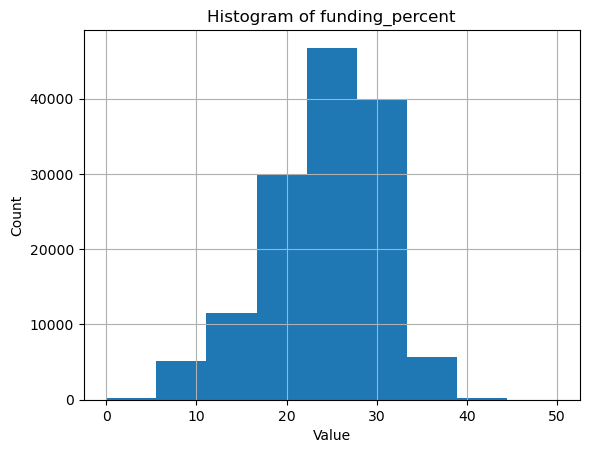

In [38]:
df.loc[:,'combined_description'] = df.loc[:,'campaign_name'] + ' ' + df.loc[:,'blurb']

bins = np.linspace(0, 50,10)

# Plotting the histogram with specified bins
df['combined_description'].str.split().apply(len).hist(bins=bins)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of funding_percent')
plt.show()

It can be observed that most samples have word count grater than 20. We set 5 as a cut-off and consider only those samples whose word count is greater than 5.

In [39]:
df= df[df['combined_description'].str.split().apply(len)>=5]

STOP_WORDS = list(text.ENGLISH_STOP_WORDS.union([str(i) for i in range(10)]))
TOKEN_PATTERN= '(?u)\\b[a-zA-Z]{2,}\\b'

MIN_DF= 0.05
THRESHOLD_RANKED_WORDS= 0.05
THRESHOLD_WORDS_FREQ= 2


blurb_is_envt = df[df['is_environmental'] == 'Yes'][['campaign_name', 'blurb']].agg(' '.join, axis=1).tolist()
blurb_is_envt = stem([text for text in blurb_is_envt])
ranked_words_envt= get_ranked_words(vocabulary= blurb_is_envt
                          ,text_extracts=blurb_is_envt, 
                          stop_words=STOP_WORDS, min_df= MIN_DF, token_pattern=TOKEN_PATTERN)

blurb_is_social = df[df['is_social'] == 'Yes'][['campaign_name', 'blurb']].agg(' '.join, axis=1).tolist()
blurb_is_social = stem([text for text in blurb_is_social])
ranked_words_social= get_ranked_words(vocabulary= blurb_is_social
                          ,text_extracts=blurb_is_social, 
                          stop_words=STOP_WORDS, min_df= MIN_DF, token_pattern=TOKEN_PATTERN)

We curate the ranked_words_envt and ranked_words_social. We remove some of the words which are not representative of the categories and add manually some words (manual pruning and curation, as explained in the section above), which we think are relevant to the category.

In [40]:
words_to_remove_envt=['design','build', 'world', 'use']
words_to_add_envt= pd.Series({(''.join(stem('green'))):0.1, (''.join(stem('e-bike'))):0.1,
                              (''.join(stem('fresh'))):0.1, (''.join(stem('environ'))):0.1,
                              })

words_to_remove_social=['area','build','live', 'project', 'public',
                         'hous', 'shirt', 'end','film','know', 'make',
                         'help','save']
words_to_add_social= pd.Series({(''.join(stem('children'))):0.1, (''.join(stem('aware'))):0.1,
                                (''.join(stem('social'))):0.1,(''.join(stem('family'))):0.1,
                                (''.join(stem('women'))):0.1,(''.join(stem('farm'))):0.1,
                                (''.join(stem('senior'))):0.1,(''.join(stem('educate'))):0.1,
                                })


ranked_words_envt = ranked_words_envt.drop(words_to_remove_envt, errors='ignore')
ranked_words_envt = pd.concat([ranked_words_envt, words_to_add_envt]).sort_values(ascending=False)
ranked_words_envt = ranked_words_envt.loc[~ranked_words_envt.index.duplicated(keep='first')]


ranked_words_social = ranked_words_social.drop(words_to_remove_social, errors='ignore')
ranked_words_social = pd.concat([ranked_words_social, words_to_add_social]).sort_values(ascending=False)
ranked_words_social = ranked_words_social.loc[~ranked_words_social.index.duplicated(keep='first')]

In [41]:
print('ranked_words_envt: \n', ranked_words_envt[ranked_words_envt >= 0.05])

ranked_words_envt: 
 organ      0.104617
green           0.1
fresh           0.1
e-bike          0.1
environ         0.1
sustain    0.095428
friend     0.064725
eco        0.061742
natur      0.055885
recycl     0.053087
farm       0.052183
dtype: Sparse[float64, 0]


In [42]:
print('ranked_words_social: \n', ranked_words_social[ranked_words_social >=0.05])

ranked_words_social: 
 support      0.135803
communiti    0.134311
senior            0.1
farm              0.1
women             0.1
family            0.1
social            0.1
aware             0.1
children          0.1
educate           0.1
covid        0.078722
solut        0.056928
fight        0.055831
dtype: Sparse[float64, 0]


We apply the findings from above and categorize the whole dataframe.

In [43]:
df_curated= df[df['is_social']!='unspecified'].copy()

df_curated= get_keywords_count(df_curated, ranked_words_envt, 'count_is_envt', 
                               column_ranked_words='ranked_words_envt', threshold=THRESHOLD_RANKED_WORDS)
df_curated= get_keywords_count(df_curated, ranked_words_social, 'count_is_social', 
                               column_ranked_words='ranked_words_social', threshold=THRESHOLD_RANKED_WORDS)
df_curated.drop(columns=['count_is_social', 'count_is_envt'],axis=1, inplace=True)

df_uncategorized= df.loc[df['is_social']=='unspecified'].copy()
df_uncategorized= get_keywords_count(df_uncategorized, ranked_words_envt, 'count_is_envt', 
                                     column_ranked_words='ranked_words_envt', threshold=THRESHOLD_RANKED_WORDS)
df_uncategorized= get_keywords_count(df_uncategorized, ranked_words_social, 'count_is_social', 
                                     column_ranked_words='ranked_words_social', threshold=THRESHOLD_RANKED_WORDS)

df_uncategorized['is_environmental'] = np.where(df_uncategorized['count_is_envt'] >= THRESHOLD_WORDS_FREQ, 'Yes', 'No')
df_uncategorized['is_social'] = np.where(df_uncategorized['count_is_social'] >= THRESHOLD_WORDS_FREQ, 'Yes', 'No')
df_uncategorized.drop(columns=['count_is_social', 'count_is_envt'],axis=1, inplace=True)

df_categorized= pd.concat([df_curated, df_uncategorized])


In [44]:
df_categorized.drop(columns=['ranked_words_envt', 'ranked_words_social'], inplace=True)

In [45]:
#Save the processed data
df_categorized.dropna(how='all', inplace=True)
df_categorized.to_csv('./data/dataframe_categorized.csv', index=False)

After saving the data, we look at some metrics.

In [46]:
shape_envt= df_categorized[df_categorized['is_environmental']=='Yes'].shape
print(f'Number of samples marked as environmentally relevant: {shape_envt[0]}; i.e, {(shape_envt[0] *100/df_categorized.shape[0]):2.3f} % of total samples')

shape_social= df_categorized[df_categorized['is_social']=='Yes'].shape
print(f'Number of samples marked as socially relevant: {shape_social[0]}; i.e, {(shape_social[0] *100/df_categorized.shape[0]):2.3f} % of total samples')

shape_success= df_categorized[df_categorized['is_success']!='fail'].shape
print(f'Number of samples marked as success: {shape_success[0]}; i.e, {(shape_success[0] *100/df_categorized.shape[0]):2.3f} % of total samples')

shape_envt_success= df_categorized[(df_categorized['is_success']!='fail') & (df_categorized['is_environmental']=='Yes')].shape
print(f'Number of environmentally successful samples: {shape_envt_success[0]}; i.e, {(shape_envt_success[0] *100/df_categorized.shape[0]):2.3f} % of total samples')


shape_social_success= df_categorized[(df_categorized['is_success']!='fail') & (df_categorized['is_social']=='Yes')].shape
print(f'Number of environmentally successful samples: {shape_social_success[0]}; i.e, {(shape_social_success[0] *100/df_categorized.shape[0]):2.3f} % of total samples')


Number of samples marked as environmentally relevant: 3221; i.e, 2.309 % of total samples
Number of samples marked as socially relevant: 3641; i.e, 2.610 % of total samples
Number of samples marked as success: 76659; i.e, 54.946 % of total samples
Number of environmentally successful samples: 1247; i.e, 0.894 % of total samples
Number of environmentally successful samples: 1709; i.e, 1.225 % of total samples


Please also note that the data can of course contain false positives and false negatives. These can be reduced by suitably adjusting the parameters mentioned in the previous sections.

### E. To Dos
--- -------------------
- Critically analyze the findings of this notebook. Try different combinations of the suggested parameters and evaluate results.
- Critically analyze the categorized dataframe
- Manually enrich the training data as suggested in the previous sections and see if it brings out better results.

In [398]:
!jupyter nbconvert --to webpdf 02.Dataset_semantic_analysis.ipynb --no-input

[NbConvertApp] Converting notebook 02.Dataset_semantic_analysis.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 123896 bytes to 02.Dataset_semantic_analysis.pdf
Task was destroyed but it is pending!
task: <Task pending name='Task-2' coro=<Connection.run() running at C:\Users\Ronin\miniforge3\envs\dl4cv\Lib\site-packages\playwright\_impl\_connection.py:274> wait_for=<Future pending cb=[Task.task_wakeup()]>>
Exception ignored in: <function _ProactorBasePipeTransport.__del__ at 0x000001FD2E7B1A80>
Traceback (most recent call last):
  File "C:\Users\Ronin\miniforge3\envs\dl4cv\Lib\asyncio\proactor_events.py", line 116, in __del__
    _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
                               ^^^^^^^^
  File "C:\Users\Ronin\miniforge3\envs\dl4cv\Lib\asyncio\proactor_events.py", line 80, in __repr__
    info.append(f'fd={self._